<a href="https://colab.research.google.com/github/shanikairoshi/QFL-with-DUN/blob/main/Qiskit_VQC_FL_MNIST_Experiemental_Anlysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from IPython.display import clear_output

Initial source - https://www.qmunity.tech/tutorials/building-a-variational-quantum-classifier

Build a quantum machine learning algorithm that classifies and recognizes handwritten digits(whether a digit is 0 or 1) present in the MNIST dataset. We will make use of several dimensional reduction techniques, perform classical pre-processing and initialize our own quantum feature maps.

In [3]:
#Install required Dependencies
!pip install --upgrade seaborn
!pip install --upgrade scikit-learn
!pip install --upgrade matplotlib
!pip install --upgrade pandas
!pip install --upgrade qiskit
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from qiskit import *
import numpy as np
from qiskit.utils import algorithm_globals
!pip install qiskit_machine_learning

import time

clear_output()

In [1]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 3142

import numpy as np
np.random.seed(algorithm_globals.random_seed)

from qiskit.utils import algorithm_globals
import numpy as np
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_machine_learning.algorithms.classifiers import VQC
#from qiskit_machine_learning.optimizers import SPSA
from qiskit import BasicAer
from qiskit import BasicAer, execute
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import QuantumInstance

#from DUNWeightingFramework import *
#This is to get client weights which get by classical learning - preprocess.

# Set random seed
algorithm_globals.random_seed = 3142
np.random.seed(algorithm_globals.random_seed)

# Define the feature map and variational form
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

# Combine feature map and variational form to create the circuit
AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw()


ModuleNotFoundError: ignored

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **STEP 01: Loading Data and Preprocessing pipeline**

In [6]:
image_size = 28 # width and length are equal
data_path= "/content/drive/MyDrive/Colab Notebooks/"
train_data = np.loadtxt(data_path + "mnist_train.csv", delimiter=",")
test_data = np.loadtxt(data_path + "mnist_test.csv", delimiter=",")

ADDITIONAL STEP : DUN TRAIN

--STRUCTURE OF THE TRAINING DATA--

The MNIST dataset has a total of  60,000 data points (rows in train_data) corresponding to digits ranging from 0 to 9
The first column has the label of the datapoint ranging from 0 to 9
The next 784 columns/features are each a 28x28 pixel grayscale image collapsed into a row. The dimension of the dataset is 784. Each of these values range from 0 to 255 where 0 corresponds to white and 255 corresponds to black and any value between 0 and 255 corresponds to a color which is a mix of black and white.
The testing dataset has the same form except it has 10000 data points. In order to get an idea of a picture of a digit inside the dataset, we will run the following code.

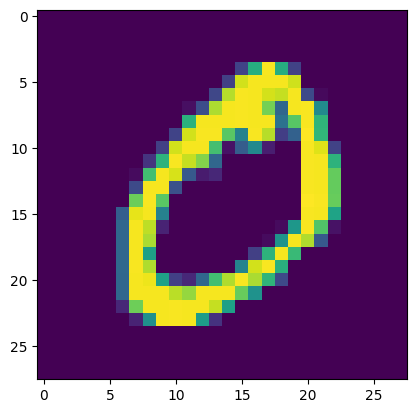

In [7]:
img = train_data[:, 1:][1].reshape((image_size, image_size))
plt.imshow(img)
plt.show()

--APPLY DIMENSIONALITY REDUCTION----

The dimension of the data corresponds to the number of qubits required in order to encode the data for the quantum feature maps we will later initialize. Since quantum computers today can only manipulate 50 qubits, we cannot work with large number of qubits like 784, therefore encoding data with dimension 784 is not viable.

Therefore, we will have to make use of the truncated Singular Value Decomposition (SVD) and t-distributed stochastic neighbor embedding (t-SNE) methods to reduce the dimension down to 10 and then to 2

784->10->2 ->require 2 quibits

In [8]:
#Extracting features and labels from the dataset and truncating the dataset to 10,000 datapoints
train_data_features = train_data[:10000, 1:]
train_data_labels = train_data[:10000, :1].reshape(10000,)

# Using SVD to reduce dimensions to 10
tsvd = TruncatedSVD(n_components=10)
X_SVD = tsvd.fit_transform(train_data_features)

# Use t-SNE technique to reduce dimensions to 2
np.random.seed(0)
tsne = TSNE(n_components=2)
train_data_features_reduced = tsne.fit_transform(X_SVD)

We will plot out the dataset to see if there is some sort of clustering due to classification of digits in the reduced dataset

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


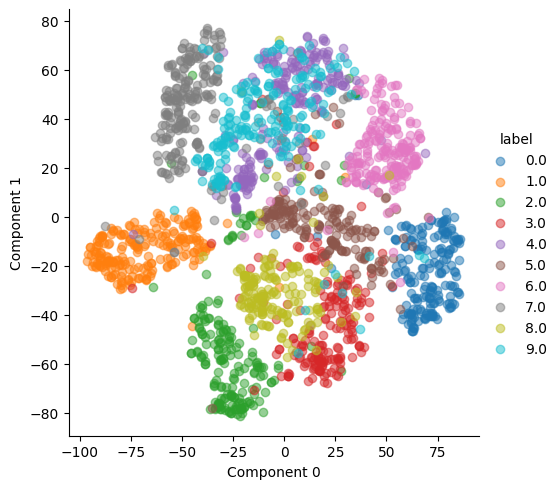

In [ ]:
# function to help plot the 2-D dataset
def plotdataset(X, Y, c1, c2, N):
    lbl1 = f'Component {c1}'
    lbl2 = f'Component {c2}'
    df = pd.DataFrame({lbl1:X[:N,c1], lbl2:X[:N,c2], 'label':Y[:N]})
    sns.lmplot(data=df, x=lbl1, y=lbl2, fit_reg=False, hue='label', scatter_kws={'alpha':0.5})
plotdataset(train_data_features_reduced, train_data_labels, 0, 1, N=2000)

--OBSERVATIONS--
0 and 1 are well separated on opposite corners as they are easily distinguishable, however, 4 and 9 are overlapping as corresponding to purple and blue data points.

## STEP 02 - EXTRACTING AND NORMALIZING DATA ***

We will extract data points corresponding to the digits 0 and 1 from the reduced dataset and normalize their features to be between 0 and 2.
We need to normalize the data because the values will be inserted into a quantum feature map

In [9]:
zero_datapoints_array = [] #an array of the data points containing value 0
one_datapoints_array = []# an array of the data points containing value 1
for i in range(10000):
    if train_data_labels[i] == 0:                   # extracting zeros
        zero_datapoints_array.append(train_data_features_reduced[i])

for i in range(10000):
    if train_data_labels[i] == 1:                   # extracting ones
        one_datapoints_array.append(train_data_features_reduced[i])

zero_datapoints_array = np.array(zero_datapoints_array)
one_datapoints_array = np.array(one_datapoints_array)

def normalize(arr, max_val, n):
    a = np.divide(arr, max_val)
    return a + n
zero_datapoints_normalized = normalize(zero_datapoints_array, 100, 1)
one_datapoints_normalized = normalize(one_datapoints_array, 100, 1)

## **STEP 03- VARIATIONAL QUANTUM CLASSFIER DEFINE**

VQC has a training stage (where data points with labels are provided and learning takes place) and a testing stage (where new data points without labels are provided which are then classified)

Tha main steps of this algorithm

1. Load Data onto the Quantum Computer by Applying a Quantum Feature Map Φ(x).
2. Build and apply short-depth Variational Circuit W(θ).
(In here depth means nub=mber of iterations for parameterixed unitaries here. it is also improve expressabilitiy because of increasing parameters with the number of reapeted times.-REsource  Amira's talk -https://www.youtube.com/watch?v=-sxlXNz7ZxU
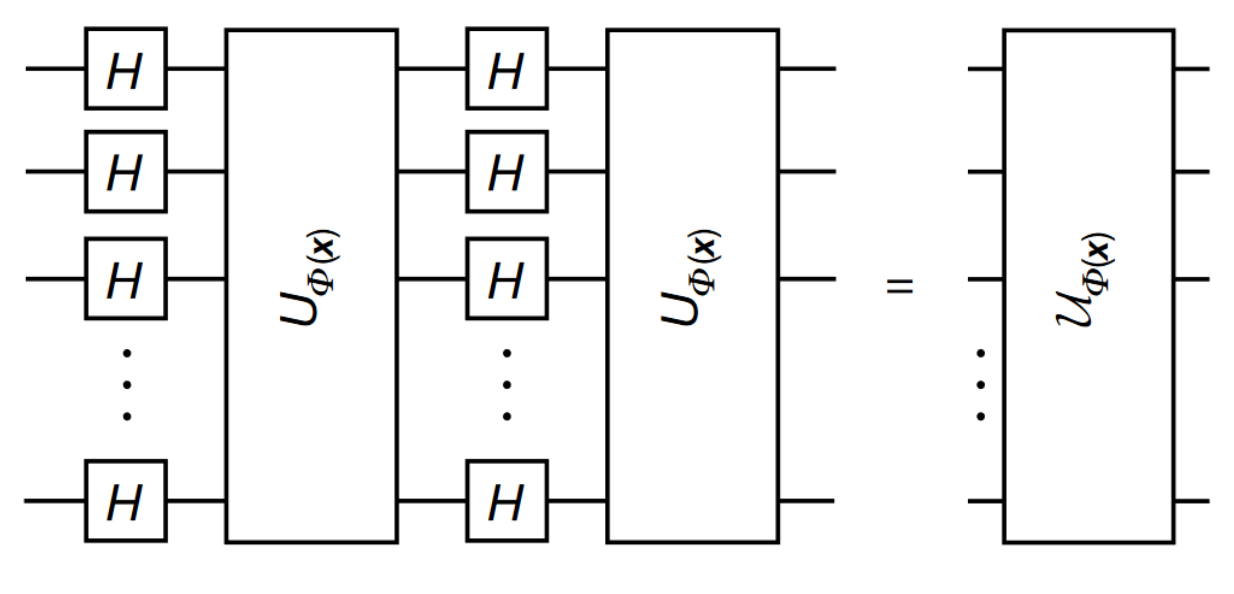


STEP 04- BUILDING FEATURE MAP-A feature map is a variational circuit.

Some of the feature maps include:

ZFeatureMap
ZZFeatureMap
PauliFeatureMap

We also want that the corresponding quantum feature map circuit is shallow( have a small circuit depth) as this reduces quantum decoherence, leading to higher accuracies.

we want to construct custom feature maps for increasing the accuracy of classification.

STEP 05- APPEND FEATURE MAPS TO VARIATIONAL CIRCUIT>

use classical optimizers in training stage.

In [10]:
from qiskit.circuit.library import RealAmplitudes

num_qubits = 2

variational_circ = RealAmplitudes(num_qubits, entanglement='full', reps=3)
#instead we can also use var_circuit = EfficientSU2(feature_dim, reps=2)



Custom feature map for optional use--
steps

Create a ParameterVector object which stores the list of Parameters
Create QuantumCircuit object
Iterative over the number of qubits and add the gates.

But this is not using in this impelementaions

#Classification Done

We will take a very small subset of 200 training datapoints and 50 testing datapoints. We also keep 5 points per label as a validation set. We will first define the training and testing inputs based on the dataset we initialized before.

In [11]:
import numpy as np

# Assuming you have the data defined as per your initial code
train_size = 200
test_size = 50
dp_size_zero = 5
dp_size_one = 5

zero_train = zero_datapoints_normalized[:train_size]
one_train = one_datapoints_normalized[:train_size]

zero_test = zero_datapoints_normalized[train_size + 1:train_size + test_size + 1]
one_test = one_datapoints_normalized[train_size + 1:train_size + test_size + 1]

training_input = {'A': zero_train, 'B': one_train}
test_input = {'A': zero_test, 'B': one_test}

datapoints = []
dp_zero = zero_datapoints_normalized[train_size + test_size + 2:train_size + test_size + 2 + dp_size_zero]
dp_one = one_datapoints_normalized[train_size + test_size + 2:train_size + test_size + 2 + dp_size_one]
datapoints.append(np.concatenate((dp_zero, dp_one)))
dp_y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
datapoints.append(dp_y)

class_to_label = {'A': 0, 'B': 1}

# Split data for 5 clients
num_clients = 5
client_data = {f'Client_{i+1}': {'TRAIN_DATA': [], 'TRAIN_LABELS': [], 'TEST_DATA': [], 'TEST_LABELS': []} for i in range(num_clients)}

for i in range(num_clients):
    start_idx = i * (train_size // num_clients)
    end_idx = (i + 1) * (train_size // num_clients)

    client_data[f'Client_{i+1}']['TRAIN_DATA'] = np.concatenate((zero_train[start_idx:end_idx], one_train[start_idx:end_idx]))
    client_data[f'Client_{i+1}']['TRAIN_LABELS'] = np.array([class_to_label['A']] * (end_idx - start_idx) + [class_to_label['B']] * (end_idx - start_idx))

    start_idx = i * (test_size // num_clients)
    end_idx = (i + 1) * (test_size // num_clients)

    client_data[f'Client_{i+1}']['TEST_DATA'] = np.concatenate((zero_test[start_idx:end_idx], one_test[start_idx:end_idx]))
    client_data[f'Client_{i+1}']['TEST_LABELS'] = np.array([class_to_label['A']] * (end_idx - start_idx) + [class_to_label['B']] * (end_idx - start_idx))

# Print client data
#for client, data in client_data.items():
    #print(f'{client}:')
    #print(data)
    #print()


**1. ZFeatureMap with Two Local**

Testing Accuracy

In [13]:
from qiskit.utils import QuantumInstance
from qiskit.utils import split_dataset_to_data_and_labels, map_label_to_class_name
seed = 10598

# initilizing backend
backend = BasicAer.get_backend('qasm_simulator')
backend_options = {"method": "statevector"}

# creating a quantum instance
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed, backend_options=backend_options)

#initilizing VQC object
#vqc = VQC(optimizer=cobyla, feature_map=feature_map, var_form=var, callback=call_back_vqc, training_dataset=training_input,
         #test_dataset=test_input, datapoints=datapoints[0])

#Measure accuracy
result = vqc.run(quantum_instance)

print("testing accuracy: {}".format(result['testing_accuracy']))
print("prediction of datapoints:")
print("Actual: {}".format(map_label_to_class_name(datapoints[1], vqc.label_to_class)))
print("prediction:   {}".format(result['predicted_classes']))

ImportError: ignored

## Experiment for Best Circuit Structure with FeatureMap for QFL Aggregation

In [16]:
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap

def CircuitStruWithFeatureMap(CircuitStructure, FeatureMap, FileName):
  # Set random seed
  algorithm_globals.random_seed = 3142
  np.random.seed(algorithm_globals.random_seed)


  #VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)
  FEATURE_MAP=FeatureMap
  VAR_FORM=CircuitStructure

  # Combine feature map and variational form to create the circuit
  AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
  AD_HOC_CIRCUIT.measure_all()
  AD_HOC_CIRCUIT.decompose().draw()

  class localOptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

  initial_point = np.random.random(VAR_FORM.num_parameters)

#Global optimizer log
  class GlobalOptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

  global_optimizer_log = GlobalOptimizerLog()

  # Initialize global model
  global_model = VQC(
    feature_map=FEATURE_MAP,
    ansatz=VAR_FORM,
    loss='cross_entropy',
    optimizer=SPSA(callback=global_optimizer_log.update),
    initial_point=initial_point,
    quantum_instance=BasicAer.get_backend('qasm_simulator')
  )


  #Local Training with Global Training
  import warnings
  warnings.filterwarnings("ignore")
  # Training settings
  num_rounds = 5
  learning_rate = 0.01  # Adjust as needed

  # Create a list of VQC instances, one for each client
  clients = []
  # Initialize an empty list to store client logs
  client_logs = []
  # Initialize an empty list to store client parameters
  client_parameters = []
  global_parameters=[]
  global_cost=[]

  # Array to store global cost
  GlobalCostperRoundAll=[]

  # Initialize global parameters
  global_parameters = np.random.rand(VAR_FORM.num_parameters)  # Initialize with random values or any desired initial values

  # Federated training loop
  for round_num in range(num_rounds):
      global_cost=[]
      client_logs=[]
      aggregated_params = np.zeros_like(global_parameters)  # Initialize aggregated parameters
      # Train each client's data on their VQC models
      for client_id, data in client_data.items():
          train_data = data['TRAIN_DATA']
          train_labels = data['TRAIN_LABELS']
          test_data = data['TEST_DATA']
          test_labels = data['TEST_LABELS']
          #train_data, train_labels, test_data, test_labels= data

          # Set up the optimization
          with warnings.catch_warnings():
              warnings.simplefilter("ignore")  # Suppress warnings
          Locallog = localOptimizerLog()
          optimizer = SPSA(maxiter=100, callback=Locallog.update)
          vqc = VQC(feature_map=FEATURE_MAP,
            ansatz=VAR_FORM,
            loss='cross_entropy',
            optimizer=SPSA(callback=Locallog.update),
            initial_point=global_parameters,
            quantum_instance=BasicAer.get_backend('qasm_simulator'))

          vqc.fit(train_data, train_labels)
          clients.append(vqc)
          client_logs.append(Locallog)
          client_parameters.append(Locallog.parameters[-1])
          cost = Locallog.costs[-1]
          print(f"Round {round_num}, Client {client_id}: parameters = {Locallog.parameters[-1]}")


      #aggregated_params = np.zeros_like(global_parameters)  # Initialize aggregated parameters
      aggregated_params = np.mean(client_parameters, axis=0)  # Calculate mean of parameters

      # Update global parameters for the next round
      global_parameters = aggregated_params
      # Aggregate client parameters
      print(f"Round {round_num},global: aggregated_gradients = {global_parameters}")

      # Update the global optimizer log with the aggregated parameters
      global_optimizer_log.parameters.append(global_parameters)
      global_model.fit(train_data, train_labels)
      global_cost = global_optimizer_log.costs
      print(f"Round {round_num},global cost: {global_cost}")

  print("Federated training done")

  import csv as csv
  # Slice the data if needed (e.g., taking the last 100 elements)
  data_to_save =global_optimizer_log.costs

  # Define the CSV file path
  csv_file_path = FileName

  # Write the data to the CSV file
  with open(csv_file_path, mode='w', newline='') as csv_file:
      writer = csv.writer(csv_file)
      writer.writerow(["Cost"])  # Write a header row if needed
      for cost in data_to_save:
          writer.writerow([cost])

  print(f"Data saved to {csv_file_path}")



In [17]:
from qiskit.circuit.library import RealAmplitudes,EfficientSU2
import csv as csv
feature_dim = 2
# Define the feature map and variational form

feature_dim = 2
FEATURE_MAPpauli = PauliFeatureMap(feature_dimension=feature_dim, reps=1, paulis = ['Z','X','ZY'])
#pauli_feature_map.draw()
FEATURE_MAPZZ = ZZFeatureMap(feature_dimension=2, reps=2)
FEATURE_MAPZ=ZFeatureMap(feature_dimension=2, reps=2)

#Test 01
variational_circ1 = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)
fileNamePauli1="TwoLocalwithPauli.csv"
fileNameZ1="TwoLocalwithZ.csv"
fileNameZZ1='TwoLocalwithZZ.csv'


CircuitStruWithFeatureMap(variational_circ1,FEATURE_MAPZ,fileNameZ1)
print("Test 01- part 1 z feature map completed")
print("---------")
CircuitStruWithFeatureMap(variational_circ1,FEATURE_MAPZZ,fileNameZZ1)
print("Test 01- part 1 zz feature map completed")
print("---------")
CircuitStruWithFeatureMap(variational_circ1,FEATURE_MAPpauli,fileNamePauli1)
print("Test 01- part 1 pauli feature map completed")
print("---------")


csv_file_pathPauliCost = "TwoLocalwithPauli.csv"
csv_file_pathZZCost = "TwoLocalwithZZ.csv"
csv_file_pathZCost = "TwoLocalwithZ.csv"

# Initialize an empty list to store the data

PauliCost = []
ZZCost=[]
ZCost=[]

print(len(ZCost))

# Read data from the CSV file and append it to the list
try:
    with open(csv_file_pathPauliCost, mode='r', newline='') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Skip the header row if present
        for row in reader:
            # Assuming the CSV file has one column
            PauliCost.append(float(row[0]))  # Convert to float if needed
except FileNotFoundError:
    print(f"The file '{csv_file_pathPauliCost}' was not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")


#================================================
# Read data from the CSV file and append it to the list
try:
    with open(csv_file_pathZZCost, mode='r', newline='') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Skip the header row if present
        for row in reader:
            # Assuming the CSV file has one column
            ZZCost.append(float(row[0]))  # Convert to float if needed
except FileNotFoundError:
    print(f"The file '{csv_file_pathZZCost}' was not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

#===============================================
# Read data from the CSV file and append it to the list
try:
    with open(csv_file_pathZCost, mode='r', newline='') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Skip the header row if present
        for row in reader:
            # Assuming the CSV file has one column
            ZCost.append(float(row[0]))  # Convert to float if needed
except FileNotFoundError:
    print(f"The file '{csv_file_pathZCost}' was not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")


#each client cost variations over epochs for whole set code
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
# Plot cost for each client over rounds
epoch = len(client_logs[0].evaluations)
#for client_id, log in enumerate(client_logs):
    #plt.plot(range(epoch), log.costs, label=f'Client {client_id + 1}', linestyle='dashed')
plt.plot(range(epoch), ZZCost[-100:], label="ZZFeatureMap", linewidth=2,color='orange')#LR=0.01, maxiter=100
#plt.plot(range(epoch), ZCost[-100:], label="global-SPSA-500", linewidth=1, marker='*',color='blue')#LR=0.01 maxiter=500
plt.plot(range(epoch), PauliCost[-100:], label="PauliFeatureMap", linewidth=2, color='red')
#plt.plot(range(epoch), global_optimizer_log.costs, label='Global Cost')
plt.plot(range(epoch), ZCost[-100:], label="ZFeatureMap", linewidth=2, color='green')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('QiskitFL Cost Evolution Different FeatureMaps-TWOLocal Circuit-Mnist Data')
plt.legend()
plt.show()


<ipython-input-16-41b26faa407b>:50: DeprecationWarning: The quantum_instance argument is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the sampler argument.
  global_model = VQC(


Round 0, Client Client_1: parameters = [ 1.31393884 -1.19309289  0.7843176   1.92041373  1.84553911  0.41011195
  1.29042509 -0.26498707 -0.9012489   0.38449667  1.43058943  0.03809466]
Round 0, Client Client_2: parameters = [ 1.95422002 -1.33755145 -0.34665978  0.11523504  2.62608659  0.05708463
  2.76017325 -1.04228594  1.64778888  2.3090827  -1.55985845  2.04009019]
Round 0, Client Client_3: parameters = [ 1.56202852 -0.93356302  2.2033384   2.18320752  0.71826673  2.97691678
  1.1367269   0.82407496  1.72033119 -1.46119393  0.80627203  0.06694916]
Round 0, Client Client_4: parameters = [ 0.62617877 -1.35265487  0.01665894  1.67776567  2.3625028   1.20062728
  0.64843053 -0.49766657 -0.09445558  1.00832834 -0.24034186  1.70995449]
Round 0, Client Client_5: parameters = [ 2.71838563  0.0124962   0.60080685  2.34293715 -0.03100198 -0.82839769
  0.04018127  0.05601435  0.25691355  1.7775289   1.03103928  2.62428999]
Round 0,global: aggregated_gradients = [ 1.63495036 -0.96087321  0.651

NameError: ignored

<Figure size 500x400 with 0 Axes>

In [ ]:


#Test 02
num_qubits=2
variational_circ2 = RealAmplitudes(num_qubits, entanglement='full', reps=3)
fileNamePauli2="RealAmplitudeswithPauli.csv"
fileNameZ2="RealAmplitudeswithZ.csv"
fileNameZZ2='RealAmplitudeswithZZ.csv'

CircuitStruWithFeatureMap(variational_circ2,FEATURE_MAPZ,fileNameZ2)
print("Test 02- part 1 z feature map completed")
print("---------")
CircuitStruWithFeatureMap(variational_circ2,FEATURE_MAPZZ,fileNameZZ2)
print("Test 02- part 1 zz feature map completed")
print("---------")
CircuitStruWithFeatureMap(variational_circ2,FEATURE_MAPpauli,fileNamePauli2)
print("Test 02- part 1 pauli feature map completed")
print("---------")

csv_file_pathPauliCost = "EfficientSU2withPauli.csv"
csv_file_pathZZCost = "EfficientSU2withZZ.csv"
csv_file_pathZCost = "EfficientSU2withZ.csv"

# Initialize an empty list to store the data

PauliCost = []
ZZCost=[]
ZCost=[]

print(len(ZCost))

# Read data from the CSV file and append it to the list
try:
    with open(csv_file_pathPauliCost, mode='r', newline='') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Skip the header row if present
        for row in reader:
            # Assuming the CSV file has one column
            PauliCost.append(float(row[0]))  # Convert to float if needed
except FileNotFoundError:
    print(f"The file '{csv_file_pathPauliCost}' was not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")


#================================================
# Read data from the CSV file and append it to the list
try:
    with open(csv_file_pathZZCost, mode='r', newline='') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Skip the header row if present
        for row in reader:
            # Assuming the CSV file has one column
            ZZCost.append(float(row[0]))  # Convert to float if needed
except FileNotFoundError:
    print(f"The file '{csv_file_pathZZCost}' was not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

#===============================================
# Read data from the CSV file and append it to the list
try:
    with open(csv_file_pathZCost, mode='r', newline='') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Skip the header row if present
        for row in reader:
            # Assuming the CSV file has one column
            ZCost.append(float(row[0]))  # Convert to float if needed
except FileNotFoundError:
    print(f"The file '{csv_file_pathZCost}' was not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")


#each client cost variations over epochs for whole set code
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
# Plot cost for each client over rounds
epoch = len(client_logs[0].evaluations)
#for client_id, log in enumerate(client_logs):
    #plt.plot(range(epoch), log.costs, label=f'Client {client_id + 1}', linestyle='dashed')
plt.plot(range(epoch), ZZCost[-100:], label="ZZFeatureMap", linewidth=2,color='orange')#LR=0.01, maxiter=100
#plt.plot(range(epoch), ZCost[-100:], label="global-SPSA-500", linewidth=1, marker='*',color='blue')#LR=0.01 maxiter=500
plt.plot(range(epoch), PauliCost[-100:], label="PauliFeatureMap", linewidth=2, color='red')
#plt.plot(range(epoch), global_optimizer_log.costs, label='Global Cost')
plt.plot(range(epoch), ZCost[-100:], label="ZFeatureMap", linewidth=2, color='green')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('QiskitFL Cost Evolution Different FeatureMaps-EfficientSU2 Circuit-Mnist Data')
plt.legend()
plt.show()

In [ ]:

#Test 03
variational_circ3=EfficientSU2(feature_dim, reps=2)
fileNamePauli3="EfficientSU2withPauli.csv"
fileNameZ3="EfficientSU2withZ.csv"
fileNameZZ3='EfficientSU2withZZ.csv'

CircuitStruWithFeatureMap(variational_circ3,FEATURE_MAPZ,fileNameZ3)
print("Test 03- part 1 z feature map completed")
print("---------")
CircuitStruWithFeatureMap(variational_circ3,FEATURE_MAPZZ,fileNameZZ3)
print("Test 03- part 1 zz feature map completed")
print("---------")
CircuitStruWithFeatureMap(variational_circ3,FEATURE_MAPpauli,fileNamePauli3)
print("Test 03- part 1 pauli feature map completed")
print("---------")
csv_file_pathPauliCost = "RealAmplitudeswithPauli.csv"
csv_file_pathZZCost = "RealAmplitudeswithZZ.csv"
csv_file_pathZCost = "RealAmplitudeswithZ.csv"

# Initialize an empty list to store the data

PauliCost = []
ZZCost=[]
ZCost=[]

print(len(ZCost))

# Read data from the CSV file and append it to the list
try:
    with open(csv_file_pathPauliCost, mode='r', newline='') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Skip the header row if present
        for row in reader:
            # Assuming the CSV file has one column
            PauliCost.append(float(row[0]))  # Convert to float if needed
except FileNotFoundError:
    print(f"The file '{csv_file_pathPauliCost}' was not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")


#================================================
# Read data from the CSV file and append it to the list
try:
    with open(csv_file_pathZZCost, mode='r', newline='') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Skip the header row if present
        for row in reader:
            # Assuming the CSV file has one column
            ZZCost.append(float(row[0]))  # Convert to float if needed
except FileNotFoundError:
    print(f"The file '{csv_file_pathZZCost}' was not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

#===============================================
# Read data from the CSV file and append it to the list
try:
    with open(csv_file_pathZCost, mode='r', newline='') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Skip the header row if present
        for row in reader:
            # Assuming the CSV file has one column
            ZCost.append(float(row[0]))  # Convert to float if needed
except FileNotFoundError:
    print(f"The file '{csv_file_pathZCost}' was not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")


#each client cost variations over epochs for whole set code
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
# Plot cost for each client over rounds
epoch = len(client_logs[0].evaluations)
#for client_id, log in enumerate(client_logs):
    #plt.plot(range(epoch), log.costs, label=f'Client {client_id + 1}', linestyle='dashed')
plt.plot(range(epoch), ZZCost[-100:], label="ZZFeatureMap", linewidth=2,color='orange')#LR=0.01, maxiter=100
#plt.plot(range(epoch), ZCost[-100:], label="global-SPSA-500", linewidth=1, marker='*',color='blue')#LR=0.01 maxiter=500
plt.plot(range(epoch), PauliCost[-100:], label="PauliFeatureMap", linewidth=2, color='red')
#plt.plot(range(epoch), global_optimizer_log.costs, label='Global Cost')
plt.plot(range(epoch), ZCost[-100:], label="ZFeatureMap", linewidth=2, color='green')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('QiskitFL Cost Evolution Different FeatureMaps-RealAmplitude Circuit-Mnist Data')
plt.legend()
plt.show()

**Experiment Results Visualization**


0


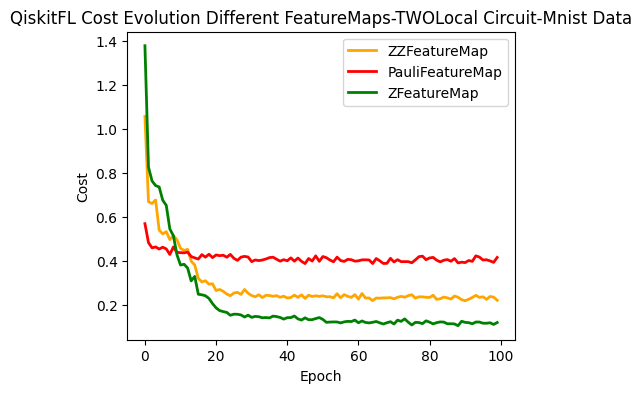

0


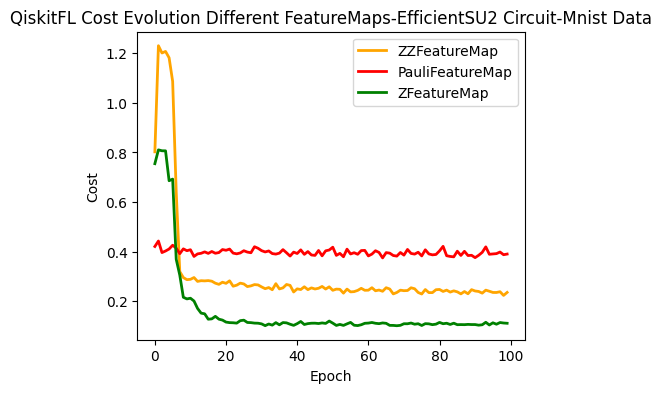

0


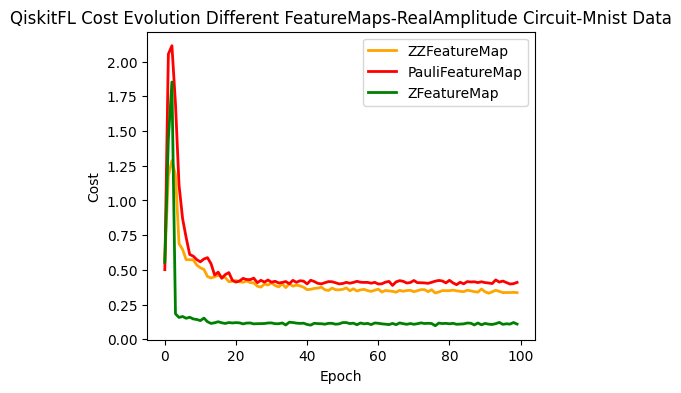

400


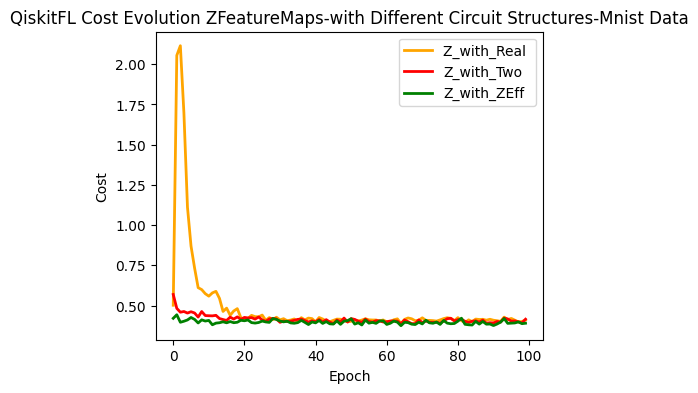

In [ ]:
csv_file_pathZTwoLocal = "TwoLocalwithPauli.csv"
csv_file_pathZReal = "RealAmplitudeswithPauli.csv"
csv_file_pathZEff = "EfficientSU2withPauli.csv"

# Initialize an empty list to store the data

ZTwoLocal = []
ZReal=[] #ZZCost
ZEff=[] #Zcost

print(len(ZCost))

# Read data from the CSV file and append it to the list
try:
    with open(csv_file_pathZTwoLocal, mode='r', newline='') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Skip the header row if present
        for row in reader:
            # Assuming the CSV file has one column
            ZTwoLocal.append(float(row[0]))  # Convert to float if needed
except FileNotFoundError:
    print(f"The file '{csv_file_pathZTwoLocal}' was not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")


#================================================
# Read data from the CSV file and append it to the list
try:
    with open(csv_file_pathZReal, mode='r', newline='') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Skip the header row if present
        for row in reader:
            # Assuming the CSV file has one column
            ZReal.append(float(row[0]))  # Convert to float if needed
except FileNotFoundError:
    print(f"The file '{csv_file_pathZReal}' was not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

#===============================================
# Read data from the CSV file and append it to the list
try:
    with open(csv_file_pathZEff, mode='r', newline='') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Skip the header row if present
        for row in reader:
            # Assuming the CSV file has one column
            ZEff.append(float(row[0]))  # Convert to float if needed
except FileNotFoundError:
    print(f"The file '{csv_file_pathZEff}' was not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")


#each client cost variations over epochs for whole set code
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
# Plot cost for each client over rounds
epoch = len(client_logs[0].evaluations)
#for client_id, log in enumerate(client_logs):
    #plt.plot(range(epoch), log.costs, label=f'Client {client_id + 1}', linestyle='dashed')
plt.plot(range(epoch), ZReal[-100:], label="Z_with_Real ", linewidth=2,color='orange')#LR=0.01, maxiter=100
#plt.plot(range(epoch), ZCost[-100:], label="global-SPSA-500", linewidth=1, marker='*',color='blue')#LR=0.01 maxiter=500
plt.plot(range(epoch), ZTwoLocal[-100:], label="Z_with_Two", linewidth=2, color='red')
#plt.plot(range(epoch), global_optimizer_log.costs, label='Global Cost')
plt.plot(range(epoch), ZEff[-100:], label="Z_with_ZEff", linewidth=2, color='green')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('QiskitFL Cost Evolution ZFeatureMaps-with Different Circuit Structures-Mnist Data')
plt.legend()
plt.show()

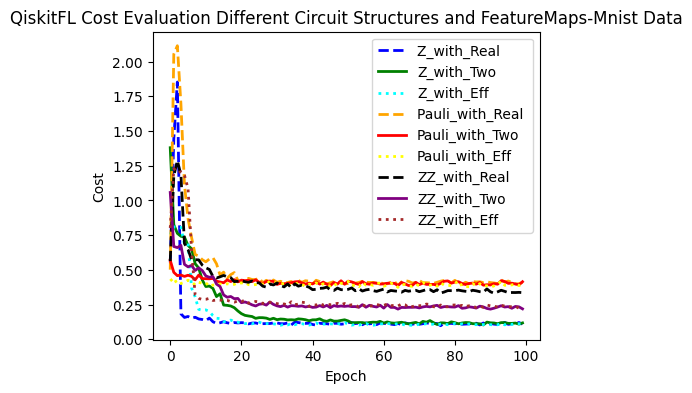

In [ ]:


csv_file_pathZTwoLocal = "global_optimizer_costsZfeatureMap.csv"
csv_file_pathZReal = "RealAmplitudeswithZ.csv"
csv_file_pathZEff = "EfficientSU2withZ.csv"

csv_file_pathPauliTwoLocal =  "global_optimizer_costsPaulifeatureMap.csv"
csv_file_pathPauliReal = "RealAmplitudeswithPauli.csv"
csv_file_pathPauliEff ="EfficientSU2withPauli.csv"

csv_file_pathZZTwoLocal = "global_optimizer_costsZZfeatureMap.csv"
csv_file_pathZZReal = "RealAmplitudeswithZZ.csv"
csv_file_pathZZEff = "EfficientSU2withZZ.csv"

# Initialize an empty list to store the data
# Initialize an empty list to store the data

ZTwoLocal = []
ZReal=[] #ZZCost
ZEff=[] #Zcost

PauliTwoLocal = []
PauliReal=[] #ZZCost
PauliEff=[] #Zcost

ZZTwoLocal = []
ZZReal=[] #ZZCost
ZZEff=[] #Zcost

#***************************ZZfeatureMap*******************************
# Read data from the CSV file and append it to the list
try:
    with open(csv_file_pathZTwoLocal, mode='r', newline='') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Skip the header row if present
        for row in reader:
            # Assuming the CSV file has one column
            ZTwoLocal.append(float(row[0]))  # Convert to float if needed
except FileNotFoundError:
    print(f"The file '{csv_file_pathZTwoLocal}' was not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")


#================================================
# Read data from the CSV file and append it to the list
try:
    with open(csv_file_pathZReal, mode='r', newline='') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Skip the header row if present
        for row in reader:
            # Assuming the CSV file has one column
            ZReal.append(float(row[0]))  # Convert to float if needed
except FileNotFoundError:
    print(f"The file '{csv_file_pathZReal}' was not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

#===============================================
# Read data from the CSV file and append it to the list
try:
    with open(csv_file_pathZEff, mode='r', newline='') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Skip the header row if present
        for row in reader:
            # Assuming the CSV file has one column
            ZEff.append(float(row[0]))  # Convert to float if needed
except FileNotFoundError:
    print(f"The file '{csv_file_pathZEff}' was not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")
#==================================================================


#***************************PaulifeatureMap*******************************

# Read data from the CSV file and append it to the list
try:
    with open(csv_file_pathPauliTwoLocal, mode='r', newline='') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Skip the header row if present
        for row in reader:
            # Assuming the CSV file has one column
            PauliTwoLocal.append(float(row[0]))  # Convert to float if needed
except FileNotFoundError:
    print(f"The file '{csv_file_pathPauliTwoLocal}' was not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")


#================================================
# Read data from the CSV file and append it to the list
try:
    with open(csv_file_pathPauliReal, mode='r', newline='') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Skip the header row if present
        for row in reader:
            # Assuming the CSV file has one column
            PauliReal.append(float(row[0]))  # Convert to float if needed
except FileNotFoundError:
    print(f"The file '{csv_file_pathPauliReal}' was not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

#===============================================
# Read data from the CSV file and append it to the list
try:
    with open(csv_file_pathPauliEff, mode='r', newline='') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Skip the header row if present
        for row in reader:
            # Assuming the CSV file has one column
            PauliEff.append(float(row[0]))  # Convert to float if needed
except FileNotFoundError:
    print(f"The file '{csv_file_pathPauliEff}' was not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")


#***************************ZZfeatureMap*******************************

try:
    with open(csv_file_pathZZTwoLocal, mode='r', newline='') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Skip the header row if present
        for row in reader:
            # Assuming the CSV file has one column
            ZZTwoLocal.append(float(row[0]))  # Convert to float if needed
except FileNotFoundError:
    print(f"The file '{csv_file_pathZZTwoLocal}' was not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")


#================================================
# Read data from the CSV file and append it to the list
try:
    with open(csv_file_pathZZReal, mode='r', newline='') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Skip the header row if present
        for row in reader:
            # Assuming the CSV file has one column
            ZZReal.append(float(row[0]))  # Convert to float if needed
except FileNotFoundError:
    print(f"The file '{csv_file_pathZZReal}' was not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

#===============================================
# Read data from the CSV file and append it to the list
try:
    with open(csv_file_pathZZEff, mode='r', newline='') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Skip the header row if present
        for row in reader:
            # Assuming the CSV file has one column
            ZZEff.append(float(row[0]))  # Convert to float if needed
except FileNotFoundError:
    print(f"The file '{csv_file_pathZZEff}' was not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")
#==================================================================

#each client cost variations over epochs for whole set code
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
# Plot cost for each client over rounds
epoch = len(client_logs[0].evaluations)
#for client_id, log in enumerate(client_logs):
    #plt.plot(range(epoch), log.costs, label=f'Client {client_id + 1}', linestyle='dashed')

plt.plot(range(epoch), ZReal[-100:], label="Z_with_Real ", linewidth=2,color='blue',linestyle='dashed')#LR=0.01, maxiter=100
#plt.plot(range(epoch), ZCost[-100:], label="global-SPSA-500", linewidth=1, marker='*',color='blue')#LR=0.01 maxiter=500
plt.plot(range(epoch), ZTwoLocal[-100:], label="Z_with_Two", linewidth=2, color='green')
#plt.plot(range(epoch), global_optimizer_log.costs, label='Global Cost')
plt.plot(range(epoch), ZEff[-100:], label="Z_with_Eff", linewidth=2, color='cyan',linestyle='dotted')


plt.plot(range(epoch), PauliReal[-100:], label="Pauli_with_Real ", linewidth=2,color='orange',linestyle='dashed')#LR=0.01, maxiter=100
#plt.plot(range(epoch), ZCost[-100:], label="global-SPSA-500", linewidth=1, marker='*',color='blue')#LR=0.01 maxiter=500
plt.plot(range(epoch), PauliTwoLocal[-100:], label="Pauli_with_Two", linewidth=2, color='red')
#plt.plot(range(epoch), global_optimizer_log.costs, label='Global Cost')
plt.plot(range(epoch), PauliEff[-100:], label="Pauli_with_Eff", linewidth=2, color='yellow',linestyle='dotted')



plt.plot(range(epoch), ZZReal[-100:], label="ZZ_with_Real", linewidth=2,color='black',linestyle='dashed')#LR=0.01, maxiter=100
#plt.plot(range(epoch), ZCost[-100:], label="global-SPSA-500", linewidth=1, marker='*',color='blue')#LR=0.01 maxiter=500
plt.plot(range(epoch), ZZTwoLocal[-100:], label="ZZ_with_Two", linewidth=2, color='purple')
#plt.plot(range(epoch), global_optimizer_log.costs, label='Global Cost')
plt.plot(range(epoch), ZZEff[-100:], label="ZZ_with_Eff", linewidth=2, color='brown',linestyle='dotted')

plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('QiskitFL Cost Evaluation Different Circuit Structures and FeatureMaps-Mnist Data')
plt.legend()
plt.show()

## Measure Accuracy

In [ ]:
result = vqc.run(quantum_instance)

print("testing accuracy: {}".format(result['testing_accuracy']))
print("prediction of datapoints:")
print("Actual: {}".format(map_label_to_class_name(datapoints[1], vqc.label_to_class)))
print("prediction:   {}".format(result['predicted_classes']))